In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
import math

## Demand and Weather
Load generated Files from before:

In [2]:
brm = pd.read_csv("../resources/bremen.csv")
frb = pd.read_csv("../resources/freiburg.csv")

brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

Create functions to create dataframes nad plots

In [3]:
def create_data(drivenframe,weatherframe): #input weather and driven data from demand
    drivenframe["trip_duration"] = drivenframe["trip_duration"].apply(pd.Timedelta)
    combined = weatherframe.join(drivenframe["trip_duration"]) #join dataframes
    daily = combined.groupby("day").agg({"trip_duration":"sum","precipitation":"mean","temperature":"mean"}) #group and aggregate data
    daily["trip_duration_in_hours"] = daily["trip_duration"].map(lambda x: (x.total_seconds() / 60 / 60))# calc trip duration in hours
    daily = daily.reset_index() #reset index
    daily["day"] = pd.to_datetime(daily["day"])
    daily["week"] = daily["day"].map(lambda x: (x.strftime("%V"))) #make 2 new colums so we can aggregate weekly
    daily["year"] = daily["day"].map(lambda x: (x.strftime("%Y")))
    
    weekly = daily.groupby(["year","week"]).agg({"trip_duration_in_hours":"sum","precipitation":"sum","temperature":"mean"})#aggergate data weekly
    weekly = weekly.reset_index()
    return [daily,weekly]

def create_plot(frame,column):
    values = frame[["precipitation","temperature","trip_duration_in_hours"]].values
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)
    demand = pd.DataFrame(scaled)
    plt.figure(figsize=(16,8))
    plt.plot(column,demand[0],label = "precipitation |"
         + " min: " + str(frame["precipitation"].min()) 
         + " max: " + str(frame["precipitation"].max()))
    plt.plot(column,demand[1],label = "temperature |"
         + " min: " + str(math.floor(frame["temperature"].min())) 
         + " max: " + str(math.floor(frame["temperature"].max())))
    plt.plot(column,demand[2],label = "trip in hours |"
         + " min: " + str(math.floor(frame["trip_duration_in_hours"].min())) 
         + " max: " + str(math.floor(frame["trip_duration_in_hours"].max())))
    plt.ylabel('normalized value')
    plt.title('demand overview daily')
    plt.legend()
    plt.show()

In [4]:
brm_daily = create_data(brm_hourly_driven,brm_hourly_weather)[0]
brm_weekly = create_data(brm_hourly_driven,brm_hourly_weather)[1]

frb_daily = create_data(frb_hourly_driven,frb_hourly_weather)[0]
frb_weekly = create_data(frb_hourly_driven,frb_hourly_weather)[1]

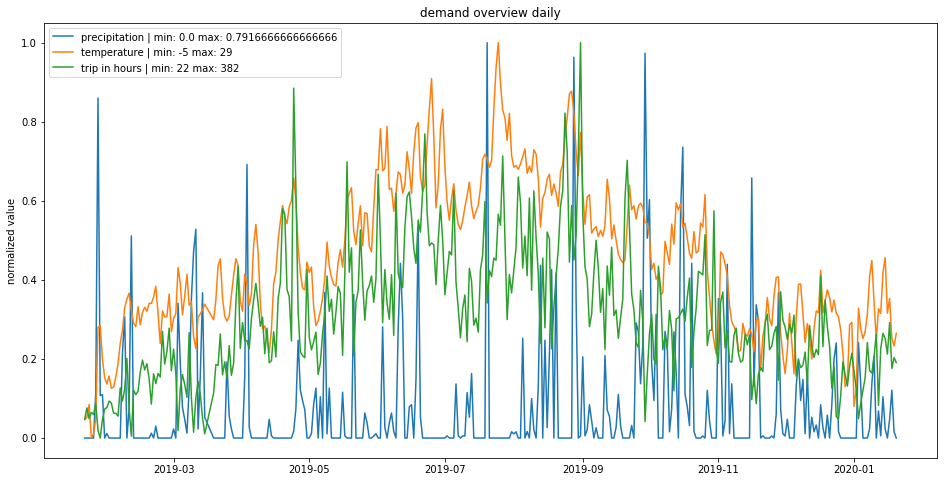

In [5]:
create_plot(brm_daily,brm_daily["day"])

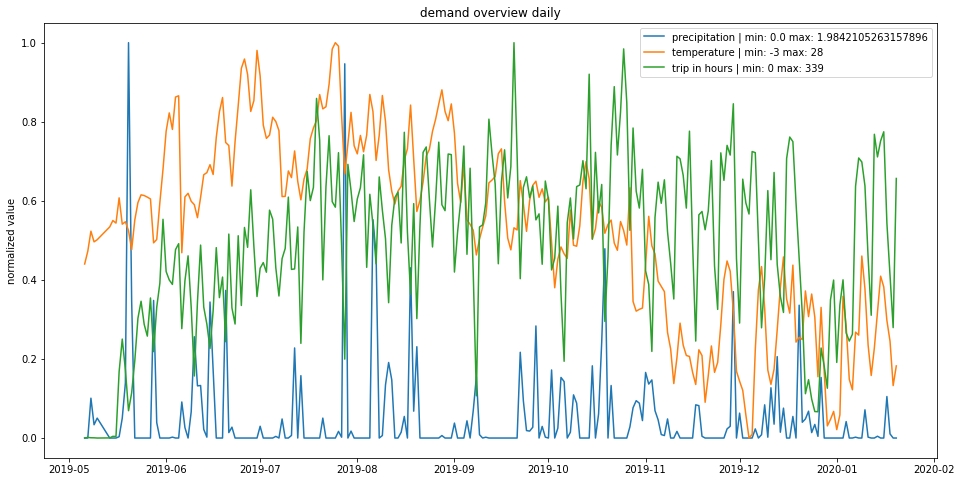

In [6]:
create_plot(frb_daily,frb_daily["day"])

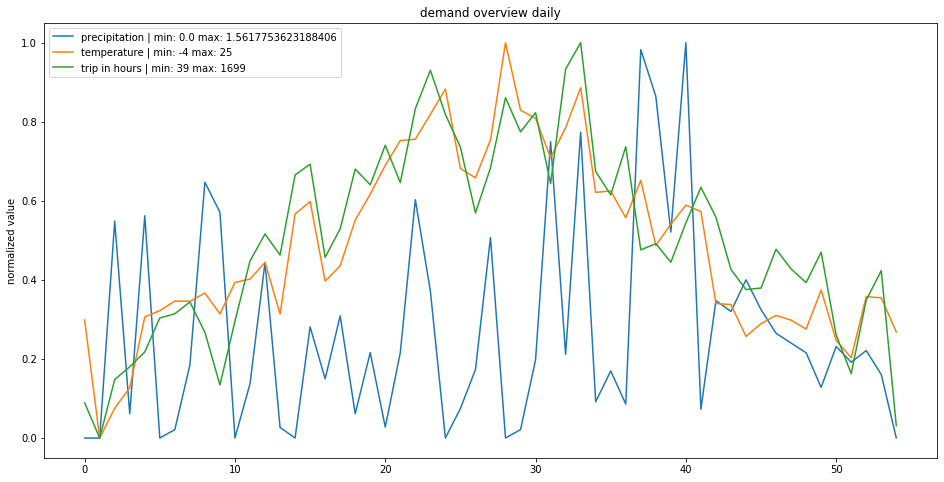

In [7]:
create_plot(brm_weekly,brm_weekly.index)

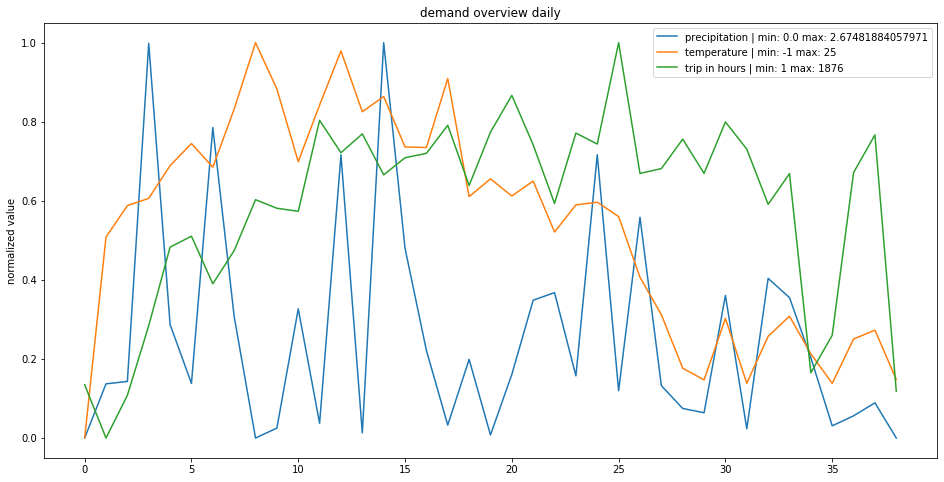

In [8]:
create_plot(frb_weekly,frb_weekly.index)